# Домашнее задание 2. Классификация, детекция.

_Селиванова Валерия ИАД-6_

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
import os
from os.path import isfile, join
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from IPython.display import clear_output
import albumentations as A
import cv2
from albumentations.pytorch import ToTensor
from PIL import Image
%matplotlib inline


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd /content/gdrive/My\ Drive

/content/gdrive/My Drive


In [ ]:
!unzip -n classification.zip

In [ ]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
#взято отсюда: https://stackoverflow.com/questions/59218671/runtimeerror-output-with-shape-1-224-224-doesnt-match-the-broadcast-shape

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.targets = []

        for i in os.listdir (data_dir):
            for k in os.listdir (data_dir + '/' + i):
                self.images.append (join (data_dir + '/' + i, k))
                self.targets.append (int(str(i).split ('_')[1]))

    def __getitem__(self, idx):
        img = pil_loader(self.images[idx])
        target = self.targets[idx]

        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.images)
        

In [ ]:
''''
Я очень пыталась использовать аугментации, но с ними ничего нормально не работало и я сдалась

train_transform = A.Compose ([
                              A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                              A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
                              A.RandomBrightnessContrast(p=0.5),
                              A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                              ToTensor()])
val_transform = A.Compose([
                           A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                           ToTensor()])
''''

In [ ]:
train_transform=transforms.Compose([
                            transforms.Resize((256, 256)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                            ])
val_transform = transforms.Compose([
                            transforms.Resize((256, 256)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

In [ ]:
train_dataset = MyDataset("./dataset/dataset/train", transform= train_transform)
val_dataset = MyDataset("./dataset/dataset/val", transform=val_transform)

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [ ]:
from torchvision.models import resnet18
model = resnet18 (pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 200)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model = model.to(device).train()

    all_losses = np.array([])
    total_predictions = np.array ([])
    total_labels = np.array ([])

    with tqdm (total = len(train_dataloader), file = sys.stdout) as pbar:
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model (images)
            loss = criterion (predicted, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_predictions = np.append (total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append (total_labels, labels.cpu().detach().numpy())
            accuracy = accuracy_score (total_labels, total_predictions)
            all_losses = np.append (all_losses, loss.cpu().detach().numpy())

            pbar.set_description (
                f'Loss: {round(loss.item(), 4)}'
                f'Accuracy {round (accuracy * 100, 4)}'
            )
            pbar.update(1)

    return accuracy, all_losses


In [ ]:
def predict(model, val_dataloader, criterion, device="cuda:0"):
    model = model.to(device).eval()
    losses = np.array ([])
    predicted_classes = np.array ([])
    true_classes = np.array ([])
    with tqdm (total = len(val_dataloader), file = sys.stdout) as pbar:
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model (images)
            loss = criterion (predicted, labels)
            
            losses = np.append (losses, loss.cpu().detach().numpy())
            predicted_classes = np.append (predicted_classes, predicted.argmax(1).cpu().detach().numpy())
            true_classes = np.append (true_classes, labels.cpu().detach().numpy())
            accuracy = accuracy_score (true_classes, predicted_classes)

            pbar.set_description(
                f'Loss: {round(loss.item(), 4)} '
                f'Accuracy: {round (accuracy * 100, 4)} '
            )
            pbar.update(1)

    return losses, predicted_classes, true_classes

In [ ]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10):
    model.to(device)
    all_train_losses = []
    epoch_val_losses = []

    for epoch in range(n_epochs):
        print (f'Train epoch: {epoch}')

        one_epoch_train_losses = train_one_epoch(
            model = model,
            train_dataloader = train_dataloader,
            optimizer = optimizer,
            criterion = criterion
        )

        all_train_losses.extend (one_epoch_train_losses)

        print (f'Val epoch: {epoch}')
        with torch.no_grad():
            losses, predicted_classes, true_classes = predict (
                model = model,
                val_dataloader = val_dataloader,
                criterion = criterion
            )
           
        epoch_val_losses.extend (losses)

    return all_train_losses, epoch_val_losses

In [ ]:
model = model
optimizer = torch.optim.Adam (model.fc.parameters(), lr=0.0001)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 16, shuffle = True, num_workers=2)
criterion = nn.CrossEntropyLoss()
n_epochs = 4
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Простой тест на проверку правильности написанного кода

In [ ]:
from tqdm import tqdm

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Loss: 5.333 Accuracy: 0.34 : 100%|██████████| 625/625 [00:28<00:00, 21.66it/s]
tests passed


Запустить обучение можно в ячейке ниже.

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs)

Train epoch: 0
Loss: 2.3924Accuracy 43.909: 100%|██████████| 6250/6250 [05:13<00:00, 19.92it/s]
Val epoch: 0
Loss: 1.9685 Accuracy: 49.51 : 100%|██████████| 625/625 [00:28<00:00, 22.30it/s]
Train epoch: 1
Loss: 2.1536Accuracy 48.181: 100%|██████████| 6250/6250 [05:06<00:00, 20.42it/s]
Val epoch: 1
Loss: 3.0673 Accuracy: 51.88 : 100%|██████████| 625/625 [00:27<00:00, 22.83it/s]
Train epoch: 2
Loss: 2.1628Accuracy 50.364: 100%|██████████| 6250/6250 [05:01<00:00, 20.73it/s]
Val epoch: 2
Loss: 1.8947 Accuracy: 52.81 : 100%|██████████| 625/625 [00:27<00:00, 23.13it/s]
Train epoch: 3
Loss: 1.7325Accuracy 51.587: 100%|██████████| 6250/6250 [04:59<00:00, 20.86it/s]
Val epoch: 3
Loss: 1.2323 Accuracy: 54.31 : 100%|██████████| 625/625 [00:27<00:00, 23.00it/s]


([0.43909,
  array([3.01892233, 3.44742441, 3.0740478 , ..., 2.49551535, 2.3269794 ,
         2.39241123]),
  0.48181,
  array([3.03468132, 1.58505416, 2.81298232, ..., 2.43270612, 2.18320966,
         2.15356898]),
  0.50364,
  array([2.10702372, 1.66823375, 2.65821695, ..., 2.8872056 , 1.8610549 ,
         2.16283464]),
  0.51587,
  array([1.67329311, 1.4729749 , 2.88591695, ..., 2.2745595 , 1.86336601,
         1.7325232 ])],
 [1.8604905605316162,
  2.556535005569458,
  1.8566256761550903,
  2.8412935733795166,
  1.7704827785491943,
  1.9101754426956177,
  2.4051713943481445,
  2.870225191116333,
  1.9497193098068237,
  2.122650623321533,
  1.4698442220687866,
  2.536113739013672,
  1.9045426845550537,
  2.14547061920166,
  2.643042802810669,
  2.4652202129364014,
  2.3447749614715576,
  1.7989106178283691,
  1.9913932085037231,
  1.8551478385925293,
  2.2955844402313232,
  2.6115026473999023,
  2.7976551055908203,
  2.0951030254364014,
  1.414409875869751,
  2.1282546520233154,
  2

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

Loss: 2.2756 Accuracy: 54.31 : 100%|██████████| 625/625 [00:27<00:00, 22.92it/s]
Оценка за это задание составит 5 баллов


__Ваш отчёт о проделанных экспериментах__: 

Я пыталась применять аугментации, но ничего не вышло.
С первого раза предобученный resnet18 с переобученным последним полносвязным слоем отлично заработал, и так как эта домашка делалась ночью 1 декабря, на этом я и остановилась. Все эксперементики сделаю в доп. задании, там-то они точно понадобятся))))))

## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [5]:
# we will need this library to process the labeling
! pip install xmltodict

In [5]:
import xmltodict, json

Датасет мы за вас написали.

In [6]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
# add any imports you need

class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [15]:
!wget https://www.dropbox.com/s/f43f2ddew1biloz/archive.zip
!unzip -q archive.zip

--2020-12-01 03:11:36--  https://www.dropbox.com/s/f43f2ddew1biloz/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/f43f2ddew1biloz/archive.zip [following]
--2020-12-01 03:11:36--  https://www.dropbox.com/s/raw/f43f2ddew1biloz/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2e7a8649746e1f84682d52e47b.dl.dropboxusercontent.com/cd/0/inline/BEObEkKOf1zLXps64CcnKp8aigEWoeftsj7AUNpZhLzEsSAkl8mK0p0U427VDhgylrwVBdGbPQW4BX-4VFfK6AZ8C48hRFwdZnfAQb_7toeTp1-cxmihem5SrFvUDYqMBIc/file# [following]
--2020-12-01 03:11:37--  https://uc2e7a8649746e1f84682d52e47b.dl.dropboxusercontent.com/cd/0/inline/BEObEkKOf1zLXps64CcnKp8aigEWoeftsj7AUNpZhLzEsSAkl8mK0p0U427VDhgylrwVBdGbPQW4BX-4VFfK6AZ8C48hRFwdZnfAQb_7toeTp1-cxmihe

In [23]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        model.eval()
        a = evaluate(model, val_dataloader, device=device)
        print("Epoch {} AUC: {}".format(epoch, round(float(a), 4)))
        model.train()
        train_one_epoch(model, train_dataloader, optimizer, device=device)

In [25]:
train_transform = A.Compose([
                             A.RandomBrightness(p=0.4),
                             A.HorizontalFlip (), 
                             A.MedianBlur(p=0.3),
                             ToTensor()], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
val_transform = A.Compose([
                           A.HorizontalFlip(),
                           ToTensor()], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_detection_model(num_classes=4):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

model = get_detection_model(num_classes=4)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD (params, lr=0.001, momentum=0.9, weight_decay=0.0005)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)
n_epochs = 10

train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)

Epoch 0 AUC: 0.0043
Loss value after 10 batches is 1.0
Loss value after 20 batches is 0.85
Loss value after 30 batches is 0.73
Loss value after 40 batches is 0.62
Loss value after 50 batches is 0.61
Loss value after 60 batches is 0.56
Loss value after 70 batches is 0.52
Loss value after 80 batches is 0.51
Loss value after 90 batches is 0.49
Loss value after 100 batches is 0.48
Loss value after 110 batches is 0.46
Loss value after 120 batches is 0.45
Epoch 1 AUC: 0.7573
Loss value after 10 batches is 0.34
Loss value after 20 batches is 0.28
Loss value after 30 batches is 0.28
Loss value after 40 batches is 0.27
Loss value after 50 batches is 0.26
Loss value after 60 batches is 0.26
Loss value after 70 batches is 0.25
Loss value after 80 batches is 0.24
Loss value after 90 batches is 0.24
Loss value after 100 batches is 0.23
Loss value after 110 batches is 0.23
Loss value after 120 batches is 0.23
Epoch 2 AUC: 0.8693
Loss value after 10 batches is 0.21
Loss value after 20 batches is 0.23

__Выведите итоговое качество модели__.

In [28]:
auc = evaluate(model, val_dataloader, device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc / 0.91)))

Оценка за это задание составит 3.9103196862800536 баллов


Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [29]:
image, labels = next(iter(train_dataset))
pred = model(image.unsqueeze(0).to(device))[0]

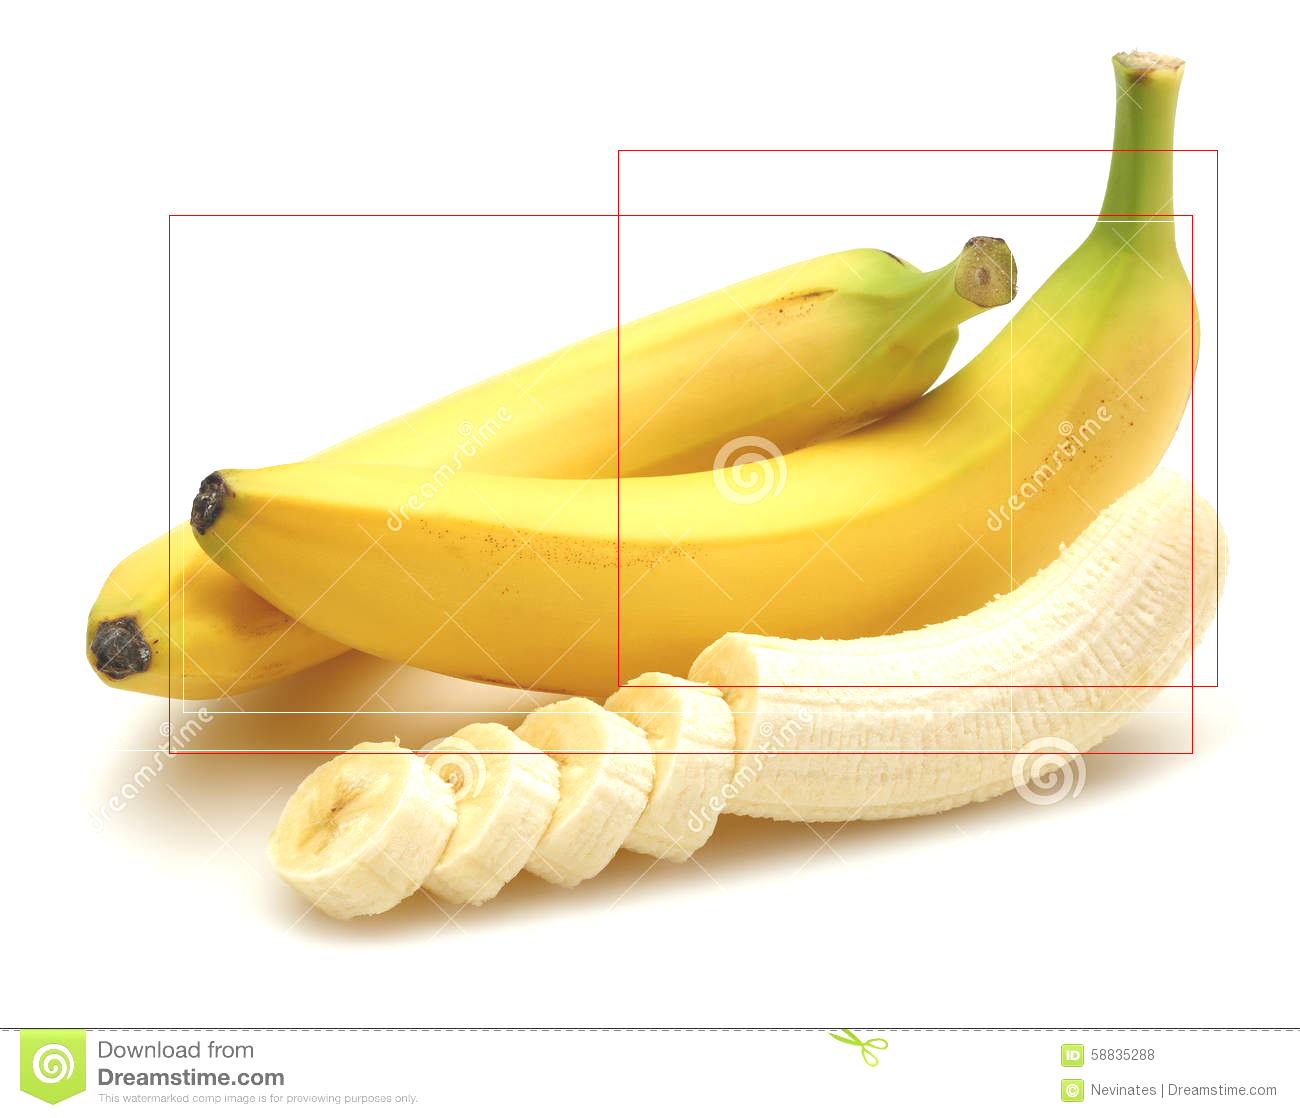

In [31]:
from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

In [ ]:
# YOUR CODE

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.